In [244]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import MultipleLocator
from tabulate import tabulate
from scipy import stats
from scipy.stats import skew, kurtosis, norm, kstest
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE

In [189]:
train_df = pd.read_csv("./train_data.csv")

In [190]:
def corr_matrix(df):
    correlation_matrix = df.corr()

    plt.figure(figsize=(25,25))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
    plt.title('Matriz de correlaciones')
    plt.show()

Primero revisamos el dataset. Antes de cualquier manipulacion de los datos, debemos explorar, entender los datos y finalmente comprender lo que deseamos hacer con los mismos. En este caso lo que se intenta es determinar si una persona es elegible para una tarjeta de credito. La variable de interes para este caso es "Is High Risk".

In [193]:
train_df.head(5)

,ID,Gender,Has a car,Has a property,Children count,Income,Employment status,Education level,Marital status,Dwelling,Age,Employment length,Has a mobile phone,Has a work phone,Has a phone,Has an email,Job title,Family member count,Account age,Is high risk
0,5037048,M,Y,Y,0,135000.0,Working,Secondary / secondary special,Married,With parents,-16271,-3111,1,0,0,0,Core staff,2.0,-17.0,0
1,5044630,F,Y,N,1,135000.0,Commercial associate,Higher education,Single / not married,House / apartment,-10130,-1651,1,0,0,0,Accountants,2.0,-1.0,0
2,5079079,F,N,Y,2,180000.0,Commercial associate,Secondary / secondary special,Married,House / apartment,-12821,-5657,1,0,0,0,Laborers,4.0,-38.0,0
3,5112872,F,Y,Y,0,360000.0,Commercial associate,Higher education,Single / not married,House / apartment,-20929,-2046,1,0,0,1,Managers,1.0,-11.0,0
4,5105858,F,N,N,0,270000.0,Working,Secondary / secondary special,Separated,House / apartment,-16207,-515,1,0,1,0,NaN,1.0,-41.0,0


El primer analisis exploratorio a realizar es si hay alguna variable que no aporta significancia al resultado. En este dataset podemos ver que el ID de un cliente no ayuda a determinar si una persona es o no elegible para tarjeta de credito. Es simplemente un valor que el banco les asignó para identificarlos.

In [194]:
train_df_step1 = train_df.drop(['ID'], axis=1)

Explorando mas a fondo, vemos que todas las personas del dataset tienen telefono movil, por lo que tampoco aporta informacion.

In [195]:
train_df_step2 = train_df_step1.drop(['Has a mobile phone'], axis=1)

[1]


Ahora nos enfocamos en el tipo de variables que hay: 
- Categoricas
    - Nominales
    - Ordinales
- Numericas
    - Discretas
    - Continuas

Las numericas no requieren transformacion, pero las categoricas si se deben convertir en numericas para poder analizarlas con cualquier modelo. Las mas sencillas son Gender, Has car y Has a property, ya que se remplazan directamente por 1 y 0.

In [196]:
with pd.option_context("future.no_silent_downcasting", True): #hacemos esto porque remplazar toda una columna de string por numeros enteros levanta sospechas a pandas
    train_df_step2['Gender'] = train_df_step2['Gender'].replace({'M': int(0), 'F': int(1)}).astype(int)
    train_df_step2['Has a car'] = train_df_step2['Has a car'].replace({'N': int(0), 'Y': int(1)}).astype(int)
    train_df_step2['Has a property'] = train_df_step2['Has a car'].replace({'N': int(0), 'Y': int(1)}).astype(int)

Employment status, Education level, Marital status, Dwelling y Job title debemos analizarlas con mas detalle para ver cuantas categorias contiene cada una.

In [197]:
print(f"Employment status: {train_df['Employment status'].unique()}\n")
print(f"Education level: {train_df['Education level'].unique()}\n")
print(f"Marital status: {train_df['Marital status'].unique()}\n")
print(f"Dwelling: {train_df['Dwelling'].unique()}\n")
print(f"Job title: {train_df['Job title'].unique()}")


Employment status: ['Working' 'Commercial associate' 'Pensioner' 'State servant' 'Student']

Education level: ['Secondary / secondary special' 'Higher education' 'Lower secondary'
 'Incomplete higher' 'Academic degree']

Marital status: ['Married' 'Single / not married' 'Separated' 'Civil marriage' 'Widow']

Dwelling: ['With parents' 'House / apartment' 'Municipal apartment'
 'Rented apartment' 'Office apartment' 'Co-op apartment']

Job title: ['Core staff' 'Accountants' 'Laborers' 'Managers' nan 'Sales staff'
 'Medicine staff' 'High skill tech staff' 'HR staff' 'Low-skill Laborers'
 'Drivers' 'Secretaries' 'Cleaning staff' 'Cooking staff' 'Security staff'
 'Private service staff' 'IT staff' 'Waiters/barmen staff' 'Realty agents']


Employment status, Marital status, Dwelling y Job title son variables nominales mientras que Education level puede considerarse ordinal. 

A las variables nominales les podriamos aplicar One Hot Encoding, pero entre todas ellas tenemos 35 valores, por lo que terminariamos con muchas mas dimensiones que variables iniciales. Podriamos utilizar Binary Encoding, pero exploremos un poco mas los datos. Una observacion importante es que Job title tiene valores nulos, pero siempre se debe analizar con cuidado los datos. Uno podria suponer que aquellas personas sin titulo de trabajo, estan desempleadas, pero no debemos suponer.

In [198]:
nan_job_df = train_df[train_df['Job title'].isna()]
print(f"Employment status: {nan_job_df['Employment status'].unique()}\n")

Employment status: ['Working' 'Pensioner' 'Commercial associate' 'State servant']



Podemos ver que efectivamente algunas personas sin Job title asignado, tienen Employment status que indica que si tienen trabajo. En este caso, el titulo del trabajo de una persona no nos brinda tanta informacion sobre su eligibilidad para recibir una tarjeta de credito (principalmente porque tenemos la informacion completa acerca de sus ingresos). Pero si se quisiera utilizar esta informacion, se podria hacer imputacion de datos (algun algoritmo de clusterizacion como KNN, asumir la moda o incluso entrenar un modelo para primero rellenar esos valores). Quitando Job title, podemos utilizar One Hot Encoding sin agregar tantas dimensiones al dataset.

In [199]:
train_df_step3 = train_df_step2.drop(['Job title'], axis=1)

train_df_step4 = pd.get_dummies(train_df_step3, columns=['Employment status', 'Education level', 'Marital status', 'Dwelling'], dtype=int)

A continuacion vamos a revisar la matriz de correlacion.

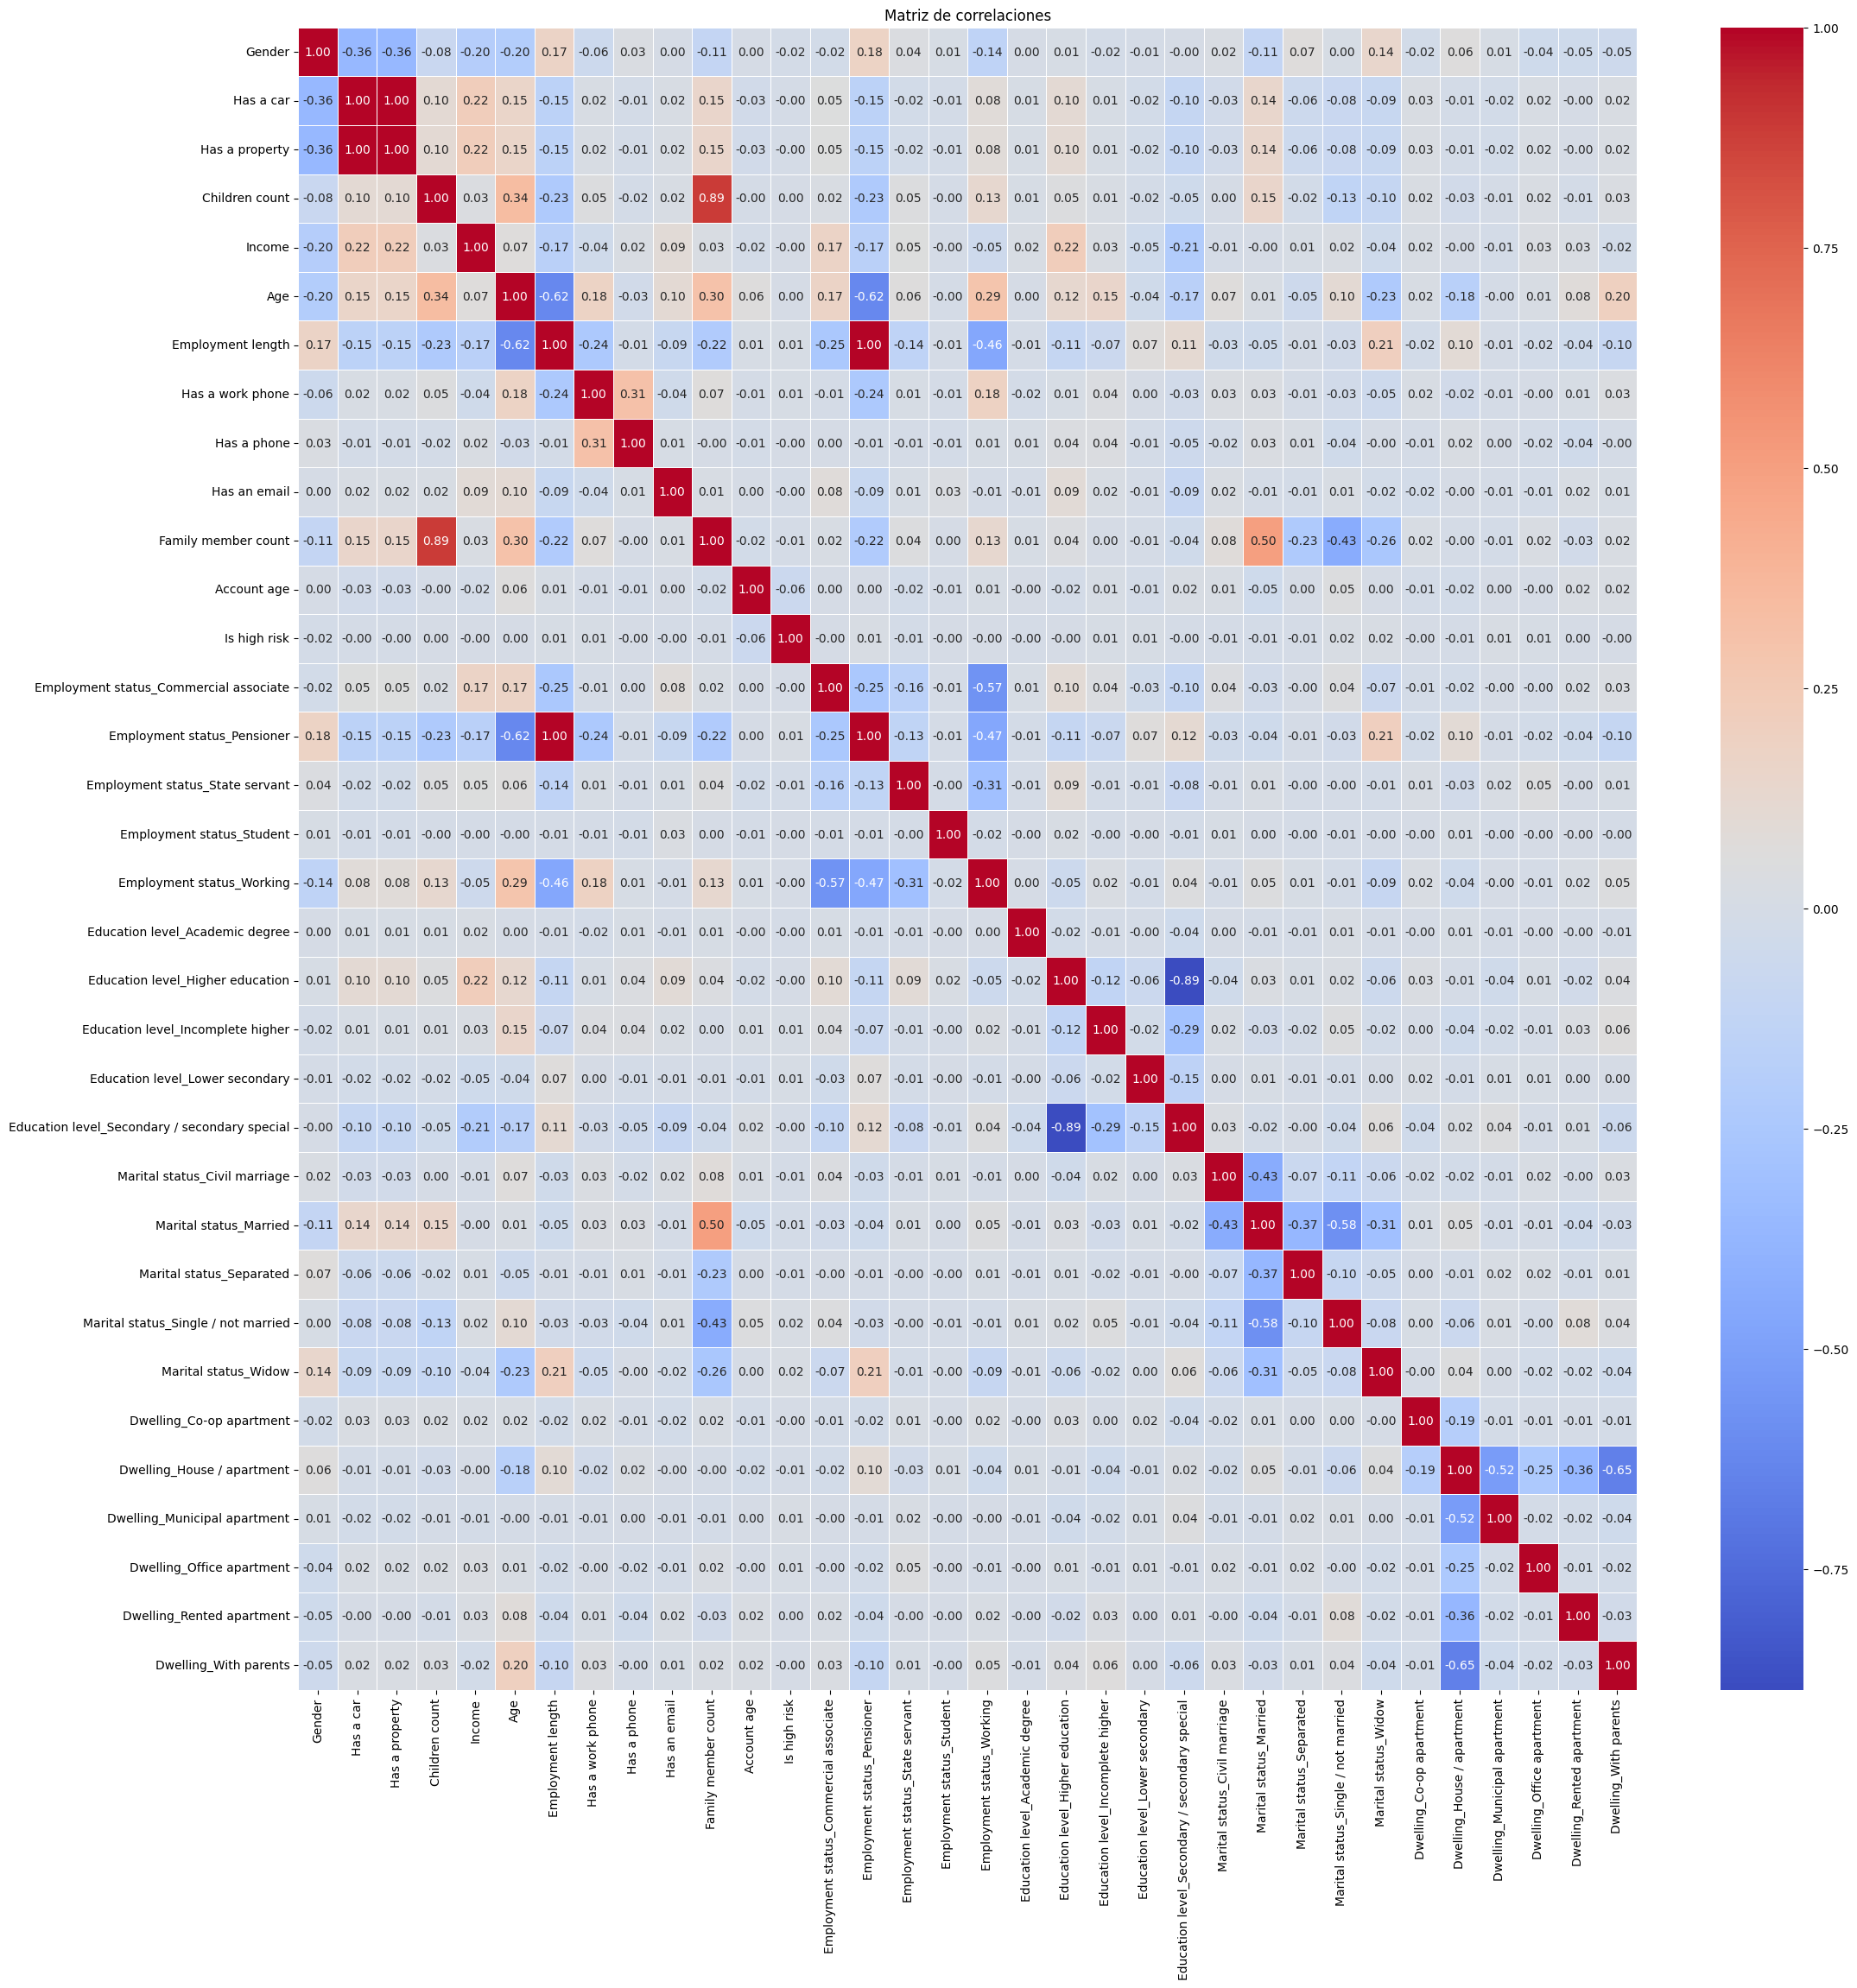

In [200]:
corr_matrix(train_df_step4)

Se pueden ver varios puntos importantes a explorar:
    1. La correlacion de 1 entre 'has a property' y 'has a car'
    2. La correlacion de 1 entre 'employment status_pensioner' y 'employment length'
    3. La alta correlacion entre 'family member count' y 'children count'

En cuanto a 'has a property' y 'has a car', hay una correlacion de 1 porque todas las personas que tienen propiedad tienen carro, y todas las personas que no tienen propiedad no tienen carro. Esta correlatividad perfecta significa que podemos eliminar una de las variables, ya que las dos variables aportan la misma informacion.

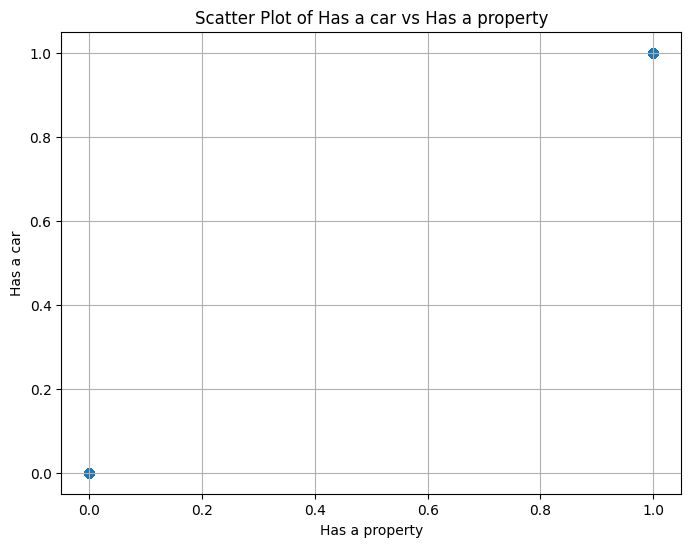

In [201]:
has_a_car = train_df_step4['Has a car']
has_a_property = train_df_step4['Has a property']

plt.figure(figsize=(8, 6))
plt.scatter(has_a_property, has_a_car)
plt.title('Scatter Plot of Has a car vs Has a property')
plt.xlabel('Has a property')
plt.ylabel('Has a car')
plt.grid(True)
plt.show()

In [202]:
train_df_step5 = train_df_step4.drop(['Has a car'], axis=1)

En cuanto a 'family member count' y 'children count', la correlatividad no es de 1 pero muy alta. Esto es de esperarse ya que la cantidad de miembros de familia esta muy relacionada a la cantidad de hijos, pero una variable toma en cuenta otro tipo de familiares. Como una variable aporta algo de informacion adicional, no podemos eliminar ninguna de ellas.

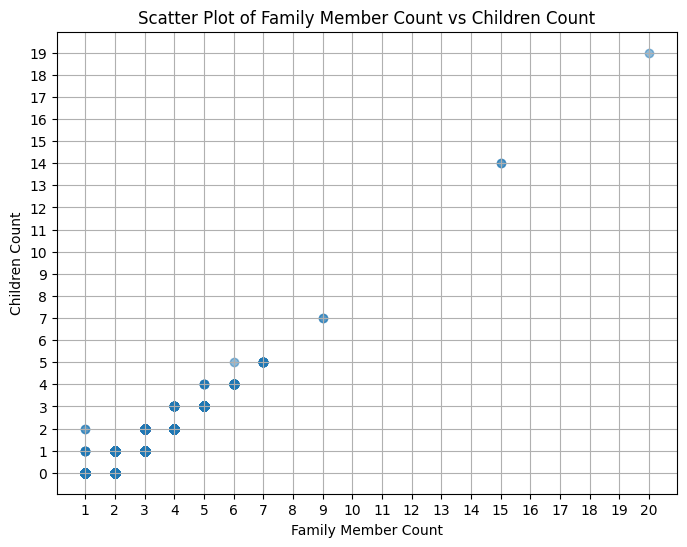

In [203]:
family_member_count = train_df_step5['Family member count']
children_count = train_df_step5['Children count']

plt.figure(figsize=(8, 6))
plt.scatter(family_member_count, children_count, alpha=0.5)
plt.title('Scatter Plot of Family Member Count vs Children Count')
plt.xlabel('Family Member Count')
plt.ylabel('Children Count')
plt.grid(True)

# Set the integer format and grid lines for both axes
plt.gca().xaxis.set_major_locator(MultipleLocator(1))
plt.gca().yaxis.set_major_locator(MultipleLocator(1))

plt.show()

Dentro de los 4908 pensionados, solo 12 tienen valor distinto a 365243 (un 0.24%). Y sobre el dataset entero, el porcentaje baja a 0.04%. En este caso se puede eliminar una de las variables, pero a diferencia de los otros casos, aqui si importa cual de las dos se elimina. Si eliminasemos employment length, se perderia toda la informacion de la gente que si tiene empleo, por lo que solamente podemos eliminar la columna de pensionados, ya que toda su informacion esta contenida en 'employment length'.

In [204]:
employment_status_pensioner = train_df_step5[(train_df_step5['Employment status_Pensioner'] == 1)]
employment_status_pensioner['Employment length'].value_counts()

Employment length
 365243    4908
-678          1
-443          1
-586          1
-672          1
-673          1
-3680         1
-2745         1
-2208         1
-620          1
-1325         1
-1644         1
-2269         1
Name: count, dtype: int64

In [205]:
train_df_step6 = train_df_step5.drop(['Employment status_Pensioner'], axis=1)

Last step should be scaling variables, since some of them like 'Income' and 'Employment length' are not proportional in scale to the others.

In [206]:
scaler = MinMaxScaler()
train_df_step7 = scaler.fit_transform(train_df_step6)
train_df_step7 = pd.DataFrame(train_df_step7, columns=train_df_step6.columns)

Best hyperparameters (): {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 10}
Accuracy on testing set: 0.9854277387279273


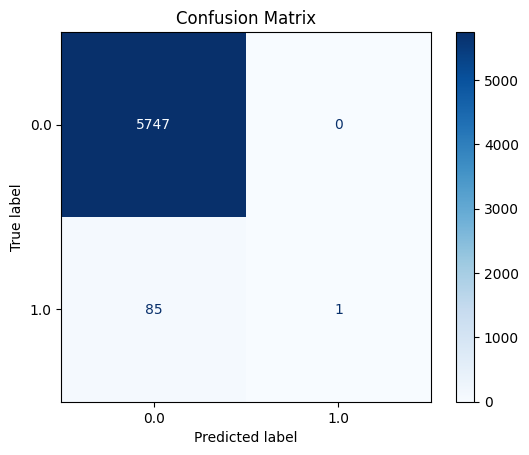

In [252]:
y_data = train_df_step7['Is high risk']
x_data = train_df_step7.drop(columns=['Is high risk'])

def train_model(x, y):
    X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)
    rf_classifier = RandomForestClassifier()
    param_grid = {
        'n_estimators': [10, 50, 100],
        'max_depth': [None, 5, 10],
        'min_samples_split': [2, 4],
        'min_samples_leaf': [1, 3]
    }

    grid_search = GridSearchCV(estimator=rf_classifier, param_grid=param_grid, cv=5, scoring='accuracy')
    grid_search.fit(X_train, y_train)

    best_params = grid_search.best_params_
    print("Best hyperparameters ():", best_params)
    best_model = grid_search.best_estimator_

    y_pred = best_model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print("Accuracy on testing set:", accuracy)
    
    # Get predictions on the test set
    y_pred = best_model.predict(X_test)

    # Generate confusion matrix
    cm = confusion_matrix(y_test, y_pred)

    # Plot confusion matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=best_model.classes_)
    disp.plot(cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.show()
    
    return best_model
    
best_model = train_model(x_data, y_data)

98.51% de precision! Esto significa que todas las observaciones que hicimos acerca del dataset fueron apropiadas y ayudaron a construir un modelo con excelente precision... o no.

Algunos modelos de machine learning, especialmente los basados en arboles, tienden a caer en una trampa cuando se trabaja con clases no balanceadas. En este dataset hay un desbalance enorme de 'Is High Risk'.

In [236]:
train_df_step7['Is high risk'].value_counts()

Is high risk
0.0    28666
1.0      499
Name: count, dtype: int64

Solamente un 1.74% de los clientes son de riesgo. Que significa esto? En vez de hacer un analisis del dataset y evaluar modelos, hiperparametros, hacer crossvalidation, etc., podriamos unicamente predecir que ningun cliente es de riesgo. Esto nos daria una precision de 98.26%, la cual es mejor que el modelo que acabamos de evaluar. Los modelos de machine learning trabajan en su mejor condicion cuando las clases estan balanceadas, asi que nuestro ultimo paso será este balance.

In [249]:
smote = SMOTE()

x_smote, y_smote = smote.fit_resample(x_data, y_data)

print('Original dataset shape')
print(y_data.value_counts())
print('\nResample dataset shape')
print(y_smote.value_counts())

Original dataset shape
Is high risk
0.0    28666
1.0      499
Name: count, dtype: int64

Resample dataset shape
Is high risk
0.0    28666
1.0    28666
Name: count, dtype: int64


Entrenamos nuevamente el modelo pero con las clases balanceadas (28666 casos de riesgo y no riesgo), y obtenemos una precision mayor a la del primer modelo, e incluso mayor a solo predecir que un cliente no es de riesgo. En la matriz de confusion podemos ver que el modelo esta debidamente prediciendo tanto clientes de riesgo como clientes que no son de riesgo.

Best hyperparameters (): {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 4, 'n_estimators': 100}
Accuracy on testing set: 0.9920641841806924


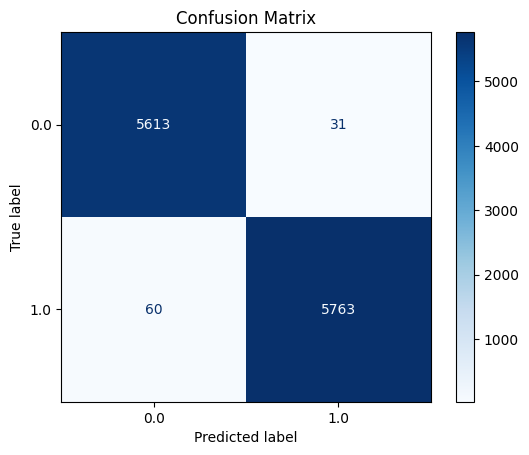

In [253]:
best_model_balanced = train_model(x_smote, y_smote)

Veamos la comparacion entre utilizar el modelo entrenado con clases balanceadas, y el modelo entrenado sin clases balanceadas. En el modelo balanceado se predijeron correctamente 388 casos de riesgo, e incorrectamente 111 casos de riesgo (77.76%). En el modelo no balanceado se predijeron correctamente 15 casos de riesgo, e incorrectamente 484 casos de riesgo (3.00%).

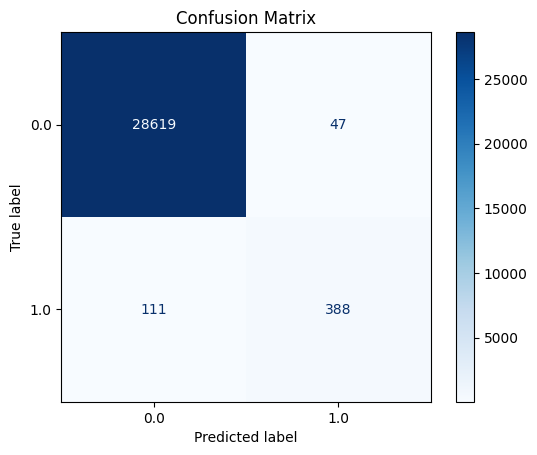

In [259]:
y_pred_balanced = best_model_balanced.predict(x_data)
balanced_accuracy = accuracy_score(y_data, y_pred_balanced)

# Generate confusion matrix
cm = confusion_matrix(y_data, y_pred_balanced)

# Plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=best_model.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

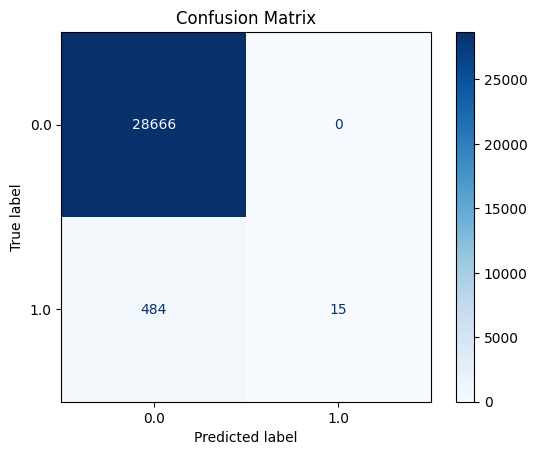

In [260]:
y_pred_unbalanced = best_model.predict(x_data)
unbalanced_accuracy = accuracy_score(y_data, y_pred_unbalanced)

# Generate confusion matrix
cm = confusion_matrix(y_data, y_pred_unbalanced)

# Plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=best_model.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

In [263]:
print(f"Accuracy on testing set with balanced training: {balanced_accuracy:.4f}%")
print(f"Accuracy on testing set with unbalanced training: {unbalanced_accuracy:.4f}%")

Accuracy on testing set with balanced training: 0.9946%
Accuracy on testing set with unbalanced training: 0.9834%
